In [1]:
# 使用深度LSTM模型进行股价的预测并绘制真实股价与之的差异性

In [3]:
# 导包
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# 导入与 LSTM 相关的1ib
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [4]:
# 下载训练数据与测试数据
train_url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(train_url)
test_url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/tatatest.csv'
dataset_test = pd.read_csv(test_url)

In [5]:
print(len(dataset_train))
dataset_train.head()

2035


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [6]:
print(len(dataset_test))
dataset_test.head()

16


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-24,220.10,221.25,217.05,219.55,219.80,2171956,4771.34
1,2018-10-23,221.10,222.20,214.75,219.55,218.30,1416279,3092.15
2,2018-10-22,229.45,231.60,222.00,223.05,223.25,3529711,8028.37
3,2018-10-19,230.30,232.70,225.50,227.75,227.20,1527904,3490.78
4,2018-10-17,237.70,240.80,229.45,231.30,231.10,2945914,6961.65


In [7]:
train_set = dataset_train.iloc[:,4].values # 选取收盘价作为训练数据
print(train_set)

[233.5  233.8  235.   ... 120.35 120.75 121.1 ]


- iloc 函数是pands中用于选取数据的函数
- 通过行和列的整数索引进行索引和选取，而不是标签进行索引
- 如，要选取第 3 行第 4 列的元素，可以使用 df.iloc[2, 3]

In [8]:
test_set = dataset_test.iloc[:,4].values
print(test_set)

[219.55 219.55 223.05 227.75 231.3  234.4  234.8  228.7  225.6  228.25
 215.   216.   210.25 217.25 226.45 230.3 ]


In [9]:
# 对价格数据进行标准化处理，基于最大值最小值进行数据范围的标准化
sc = MinMaxScaler(feature_range=(0,1))
# 因为我们的输入是一维的数据，而fit_transform要求输入是二维的数据，所以需要reshape为二维向量
# 此处reshape为 2035 x 1 维度的向量
training_set_scaled = sc.fit_transform(train_set.reshape(-1,1))
# print(training_set_scaled)
testing_set_scaled = sc.fit_transform(test_set.reshape(-1,1))
# print(testing_set_scaled)

- MinMaxScaler 是一个在机器学习中常用的特征缩放工具，它将数据缩放到一个指定的最小和最大值之间。它可以使得数据更加稳定，加快模型的收敛速度
- 通常用于将数值型数据的值缩放到一个固定的范围，例如 [0, 1]。它通过计算每个特征的最小值和最大值，然后对每个特征进行以下线性变换
- X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
- X_scaled = X_std * (max - min) + min
- 其中，X 是原始数据，X_scaled 是缩放后的数据，min 和 max 是指定的最小值和最大值
- MinMaxScaler 函数在模型训练之前对输入数据进行预处理（fit_transformer函数），并且在预测时也需要使用相同的转换（inverse_transform函数）来保证结果的一致性

In [10]:
# 创建训练数据的结构
x_train = []
y_train = []
# 基于前60天的数据做训练，预测第61天的数据
for i in range(60, 2035):
    x_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
# print(x_train.shape) (1975, 60)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
# print(x_train.shape) (1975, 60, 1)
    

In [11]:
# 神经网络的结构为四层 LSTM + 4次 Dropout + 1层全连接
# 可以使用LSTM模型的dropout参数和recurrent_drop参数进行正则化处理
# 除最后一层外，每层LSTM模型均为下一级LSTM输送参数
# LSTM 模型中的参数为64
# 每次Dropout防治过拟合的比例为20%
# 因为要预测股票价格，所以全连接层使用线性回归
model = Sequential()
model.add(LSTM(units = 64, return_sequences = True,dropout = 0.2,recurrent_dropout=0.2, input_shape=(x_train.shape[1],1)))
# model.add(Dropout(0.2))
model.add(LSTM(units=64,return_sequences=True, dropout = 0.2,recurrent_dropout=0.2))
# model.add(Dropout(0.2))
model.add(LSTM(units=64,return_sequences=True, dropout = 0.2,recurrent_dropout=0.2))
# model.add(Dropout(0.2))
model.add(LSTM(units=64, dropout = 0.2,recurrent_dropout=0.2))
# model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))
# 使用 Adam 优化器和均方误差损失函数
model.compile(optimizer='adam',loss='mean_squared_error')
# 训练执行100轮，每轮的数据大小为32个
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
62/62 [==============================] - 16s 159ms/step - loss: 0.0105
Epoch 2/50
62/62 [==============================] - 10s 165ms/step - loss: 0.0036
Epoch 3/50
62/62 [==============================] - 10s 167ms/step - loss: 0.0031
Epoch 4/50
62/62 [==============================] - 10s 159ms/step - loss: 0.0036
Epoch 5/50
62/62 [==============================] - 10s 158ms/step - loss: 0.0030
Epoch 6/50
62/62 [==============================] - 10s 161ms/step - loss: 0.0028
Epoch 7/50
62/62 [==============================] - 11s 173ms/step - loss: 0.0029
Epoch 8/50
62/62 [==============================] - 10s 167ms/step - loss: 0.0025
Epoch 9/50
62/62 [==============================] - 11s 175ms/step - loss: 0.0026
Epoch 10/50
62/62 [==============================] - 10s 166ms/step - loss: 0.0028
Epoch 11/50
62/62 [==============================] - 11s 173ms/step - loss: 0.0025
Epoch 12/50
62/62 [==============================] - 10s 165ms/step - loss: 0.0026
Epoch 13/50
6

Keras 中的 LSTM 模型有许多可调节的参数
- units：LSTM 层中每个单元的单元数。这个值决定了 LSTM 层中有多少个神经元，也就是模型能学到的信息量，该值一般设置为一个较大的数，例如 64,128 等
- activation：激活函数，用于在 LSTM 单元中对输入数据进行非线性变换。常用的激活函数有 'tanh' 和 'relu'
- recurrent_activation：循环激活函数，用于在 LSTM 单元中对循环数据进行非线性变换。常用的激活函数有 'sigmoid' 和 'hard_sigmoid'
- return_sequences：是否返回序列中的所有时间步的输出。如果设置为 True，返回输出为 (batch_size, timesteps, units)，否则返回输出为 (batch_size, units) 当仅有一层LSTM 层时无需return sequence
- dropout：为输入和循环输入应用的 dropout 比率。这个参数可以防止过拟合
- recurrent_dropout：循环输入应用的 dropout 比率。这个参数可以防止过拟合
- input_shape：模型的输入形状。如果是第一层，需要指定输入的形状，否则可以不指定，input_shape 的值应该是一个 tuple，其中包含三个元素
    - 第一个元素表示样本数量，对于训练数据而言，可以设置为 None，表示样本数量可变
    - 第二个元素表示时间步数，即序列中每个时间步的输入数据的维度
    - 第三个元素表示特征数量，即输入数据中每个时间步的特征数量
    - 如果你有 100 个样本，每个样本有 10 个时间步，每个时间步有 5 个特征，那么 input_shape 应该设置为 (10,5), 或者(None,10,5)

In [12]:
# 为了进行test估价的预测，需要使用test数据集的timestamp - 60 天的数据进行训练
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
# 将数据进行归一化
inputs = sc.transform(inputs)
x_test = []
for i in range(60, 76):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# 使用模型预测数据
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

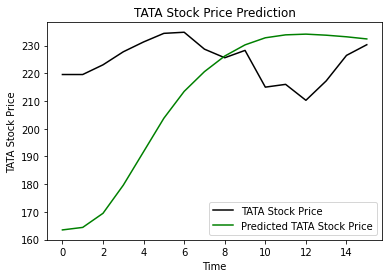

In [13]:
# 绘制图片
# 即使预测曲线无法贴近真实估价，但是可以看到趋势还是略有符合的
plt.plot(test_set, color = 'black', label = 'TATA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

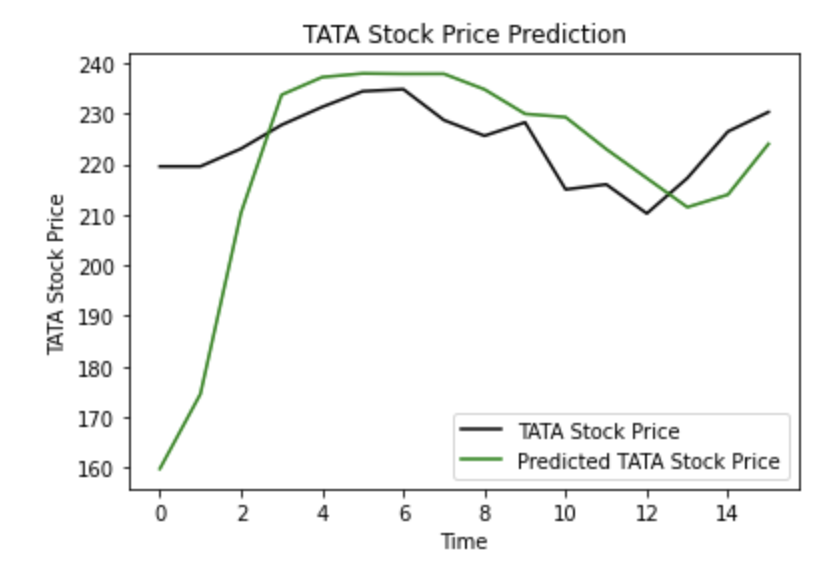
- 使用drop层时的训练结果
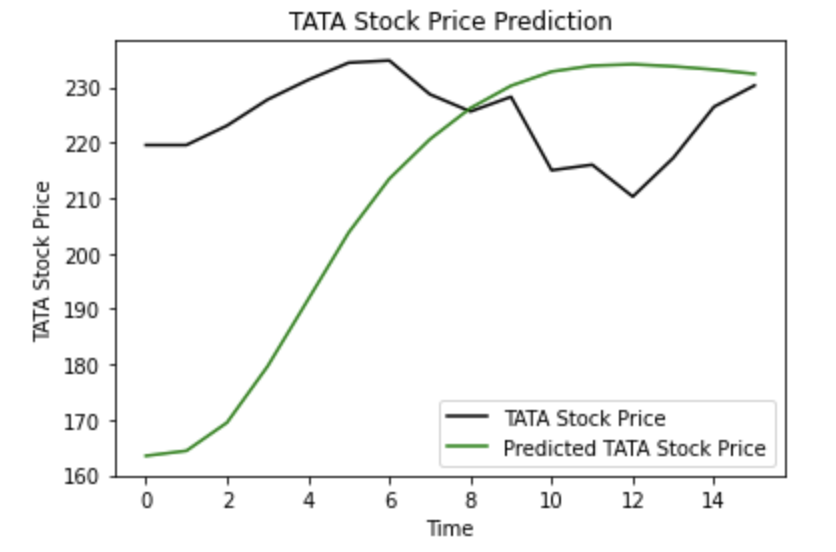
- 使用LSTM正则项时的训练结果